# Stock Predicting
We have used several methods to implement the prediction. The data are seperated into 2 parts where the first part is about the indicators and the second part is about the raw data. The raw data will be used by feature tools later to generate some amazing data

In [1]:
import csv, datetime, time, random
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from data_reader import DataLoader
from sklearn.decomposition import PCA
import pandas as pd
import tqdm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
import os, pickle
from data_reader import DataLoader
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
TMP = ''

class Data():
    """
    Loading a single line of the data

    """
    def __init__(self, data):
        self.fv = [float(d) for d in data[:108]]
        self.midprice = float(data[108])
        self.uptime = data[109]
        self.lastprice = float(data[111])
        self.volume = float(data[112])
        self.lastvolume = float(data[113])
        self.turnover = float(data[114])
        self.lastturnover = float(data[115])
        self.askprice = [float(data[120]), float(data[119]), float(data[118]), float(data[117]), float(data[116])]
        self.bidprice = [float(data[121]), float(data[122]), float(data[123]), float(data[124]), float(data[125])]
        self.askvolume = [float(data[130]), float(data[129]), float(data[128]), float(data[127]), float(data[126])]
        self.bibdvolume = [float(data[131]), float(data[132]), float(data[133]), float(data[134]), float(data[135])]
        self.openinterest = float(data[136])
        self.upper = float(data[137])
        self.lower = float(data[138])
        self.day = 0
        self.apm = ''

        self.init_time()

    def get_feature_vector(self):
        return np.array(self.fv)

    def init_time(self):
        """
        Init time of the single line data

        """
        time_digit = self.uptime
        param = time_digit.split(':')
        h = int(param[0])
        m = int(param[1])
        s = int(param[2])
        self.uptime = datetime.time(h, m, s)
        if self.uptime > datetime.time(12,0,0):
            self.apm = 'pm'
        else:
            self.apm = 'am'


def get_fromcsv(root):
    """
    Reading the data from csv simutaniously wash out the data that across two days

    """
    flag = False
    dataset = []
    begin = time.time()
    last_time = datetime.time(0,0,0)
    day_count = 0
    global TMP
    with open(root, 'r') as f:
        datafile = csv.reader(f)
        for line in datafile:
            if flag:
                TMP = line
                data = Data(line)
                dataset.append(data)
                if data.uptime < last_time:
                    day_count += 1
                    data.day = day_count
                    #print(data.day)

                # if day_count == 3:
                #     break

                last_time = data.uptime
            else:
                flag = True
    end = time.time()
    print('dataset length:\t{}\ttime:\t{}'.format(len(dataset), end - begin))
    return dataset

def merge_data(simdatas):
    newdata = Data(TMP)
    l = len(simdatas)
    new_fv = [0 for i in range(108)]
    new_midprice = 0
    new_lastvolume = 0
    new_lastturnover = 0
    new_askprice = [0 for i in range(5)]
    new_bidprice = [0 for i in range(5)]
    new_askvolume = [0 for i in range(5)]
    new_bidvolume = [0 for i in range(5)]
    lastdata = simdatas[-1]
    for data in simdatas:
        for i in range(108):
            new_fv[i] += data.fv[i]
        new_midprice += data.midprice
        new_lastvolume += data.lastvolume
        new_lastturnover += data.lastturnover
        for i in range(5):
            new_askprice[i] += data.askprice[i]
            new_bidprice[i] += data.bidprice[i]
            new_askvolume[i] += data.askvolume[i]
            new_bidvolume[i] += data.bibdvolume[i]

    for i in range(108):
        new_fv[i] /= l

    new_midprice /= l
    new_lastvolume /= l
    new_lastturnover /= l

    for i in range(5):
        new_askprice[i] /= l
        new_bidprice[i] /= l
        new_askvolume[i] /= l
        new_bidvolume[i] /= l

    newdata.fv = new_fv
    newdata.midprice = new_midprice
    newdata.uptime = lastdata.uptime
    newdata.lastprice = lastdata.lastprice
    newdata.volume = lastdata.volume
    newdata.lastvolume = new_lastvolume
    newdata.turnover = lastdata.turnover
    newdata.lastturnover = new_lastturnover
    newdata.askprice = new_askprice
    newdata.bidprice = new_bidprice
    newdata.askvolume = new_askvolume
    newdata.bibdvolume = new_bidvolume
    newdata.openinterest = lastdata.openinterest
    newdata.upper = lastdata.upper
    newdata.lower = lastdata.lower
    newdata.day = lastdata.day
    newdata.apm = lastdata.apm

    return newdata

def clean_data(dataset):
    """
    Wash out the data that is at the same time

    """
    last_time = dataset[0].uptime
    simdatas = []
    new_dataset = []
    for data in dataset:
        if data.uptime == last_time:
            simdatas.append(data)
        else:
            new_dataset.append(merge_data(simdatas))
            simdatas = [data]
            last_time = data.uptime

    if len(simdatas) > 0:
        new_dataset.append(merge_data(simdatas))

    return new_dataset

def get_raw_label(new_dataset, n, seq_len, sample_gap):
    data_day_order = []
    tmp = []
    apm = 'am'
    dataset = []
    labels = []
    for data in new_dataset:
        if data.apm == apm:
            tmp.append(data)
        else:
            data_day_order.append(tmp)
            tmp = [data]
            apm = 'pm' if apm == 'am' else 'am'

    for i, data_batch in enumerate(data_day_order):
        data_day_order[i] = data_batch[:-1 * n]
        sample_num = (len(data_day_order[i]) // sample_gap) - 1
        for j in range(sample_num):
            left = j * sample_gap
            mid = left + seq_len
            right = left + seq_len + n
            tmp = []
            for k in range(left, mid):
                tmp.append(data_day_order[i][k].midprice)
                tmp.append(data_day_order[i][k].lastprice)
                tmp.append(data_day_order[i][k].volume)
                tmp.append(data_day_order[i][k].lastvolume)
                tmp.append(data_day_order[i][k].turnover)
                tmp.append(data_day_order[i][k].lastturnover)
                tmp.append(data_day_order[i][k].upper)
                tmp.append(data_day_order[i][k].lower)
                tmp.extend(data_day_order[i][k].askprice)
                tmp.extend(data_day_order[i][k].bidprice)
                tmp.extend(data_day_order[i][k].askvolume)
                tmp.extend(data_day_order[i][k].bibdvolume)
            dataset.append(tmp)
            current = data_day_order[i][mid - 1].askprice[0] + data_day_order[i][mid - 1].bidprice[0]
            future = data_day_order[i][right - 1].askprice[0] + data_day_order[i][right - 1].bidprice[0]
            label = (future - current) / 2
            labels.append(label)

    print('total data:\t{}\ttotal labels:\t{}'.format(len(dataset), len(labels)))

    return dataset, labels

def get_indicator_label(new_dataset, n, seq_len, sample_gap):
    data_day_order = []
    tmp = []
    apm = 'am'
    dataset = []
    labels = []
    for data in new_dataset:
        if data.apm == apm:
            tmp.append(data)
        else:
            data_day_order.append(tmp)
            tmp = [data]
            apm = 'pm' if apm == 'am' else 'am'

    for i, data_batch in enumerate(data_day_order):
        data_day_order[i] = data_batch[:-1 * n]
        sample_num = (len(data_day_order[i]) // sample_gap) - 1
        for j in range(sample_num):
            left = j * sample_gap
            mid = left + seq_len
            right = left + seq_len + n
            tmp = []
            for k in range(left, mid):
                tmp.append(data_day_order[i][k].fv)
            dataset.append(tmp)
            current = data_day_order[i][mid - 1].askprice[0] + data_day_order[i][mid - 1].bidprice[0]
            future = data_day_order[i][right - 1].askprice[0] + data_day_order[i][right - 1].bidprice[0]
            label = (future - current) / 2
            labels.append(label)

    print('total data:\t{}\ttotal labels:\t{}'.format(len(dataset), len(labels)))

    return dataset, labels

def divid_dataset(dataset, labels):
    """
    Divide the dataset into train, validation & test

    """
    l = len(dataset)
    idx_list = list(range(l))
    random.shuffle(idx_list)

    train_range = int(l * 0.8)
    dev_range = int(l * 0.9)

    train_input = []
    train_label = []
    dev_input = []
    dev_label = []
    test_input = []
    test_label = []

    for i in range(train_range):
        idx = idx_list[i]
        train_input.append(dataset[idx])
        train_label.append(labels[idx])

    for i in range(train_range, dev_range):
        idx = idx_list[i]
        dev_input.append(dataset[idx])
        dev_label.append(labels[idx])

    for i in range(dev_range, l):
        idx = idx_list[i]
        test_input.append(dataset[idx])
        test_label.append(labels[idx])

    print('train set size:\t{}\tdevelop set size:\t{}\ttest set size:\t{}'.format(len(train_input), len(dev_input), len(test_input)))

    return (train_input, train_label), (dev_input, dev_label), (test_input, test_label)

def DataLoader(root, N, seq_len, sample_gap, type=True, dev_bs = 1, test_bs = 1):
    """
    root : the place of the csv file
    N : the n-th future prediction
    seq_len : the n future data used to predict the result
    sample_gap : stride of the data using

    """
    dataset = get_fromcsv(root)
    dataset = clean_data(dataset)
    print(np.array(dataset).shape)
    if type:
        dataset, labels = get_indicator_label(dataset, N, seq_len, sample_gap)
    else:
        dataset, labels = get_raw_label(dataset, N, seq_len, sample_gap)
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = divid_dataset(dataset, labels)

    return (np.array(train_input), np.array(train_label)), (np.array(dev_input), np.array(dev_label)), (np.array(test_input), np.array(test_label))

### Using Different Methods to do regression

In [8]:
N = 10
seq_len = 30
sample_gap = 30

if os.path.exists(path="./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)

"""
Train input shape N_samples * seq_len * 108
Train label shape N_samples * 1

"""
def CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    train_input = train_input.reshape(train_input.shape[0], train_input.shape[1], int(train_input.shape[2] / 3), 3)
    test_input = test_input.reshape(test_input.shape[0], test_input.shape[1], int(test_input.shape[2] / 3), 3)
    dev_input = dev_input.reshape(dev_input.shape[0], dev_input.shape[1], int(dev_input.shape[2] / 3), 3)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', input_shape=(train_input.shape[1], train_input.shape[2], train_input.shape[3])))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    CNNIndicatorPred = model.predict(test_input)
    CNNacc = np.std(CNNIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return CNNacc
CNNacc = CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(CNNacc)
# print(pred.shape, test_label.shape)

dataset length:	1721577	time:	288.38901805877686
(576093,)
total data:	18864	total labels:	18864
train set size:	15091	develop set size:	1886	test set size:	1887
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 34, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 12, 64)         36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 6, 64) 

In [21]:
def AdaRegress(X, y, n_estimators, random_st):
    regr = AdaBoostRegressor(n_estimators=n_estimators, random_state=random_st)
    regr.fit(X, y)
    return regr

if os.path.exists(path="./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)

pca = PCA(n_components=540)
train_input = train_input.reshape(train_input.shape[0], -1)
dev_input = dev_input.reshape(dev_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)
train_input = pca.fit_transform(train_input)
dev_input = pca.fit_transform(dev_input)
test_input = pca.fit_transform(test_input)

regressor = AdaRegress(train_input, np.array(train_label), 100, 0)

AdaIndicatorPred = regressor.predict(test_input)
AdaBoostacc = np.std(AdaIndicatorPred - np.array(test_label))
print(AdaBoostacc)

1.5704781815193638


In [22]:
model = Sequential()
model.add(Dense(128, input_shape=(train_input.shape[1], ), kernel_initializer='uniform', activation='sigmoid', kernel_regularizer=keras.regularizers.l1(0.)))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.summary()

callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

DNNIndicatorPred = model.predict(test_input)
DNNacc = np.std(DNNIndicatorPred - test_label.reshape(test_label.shape[0], 1))
print(DNNacc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               69248     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 9         
Total params: 73,649
Trainable params: 73,649
Non-trainable params: 0
_________________________________________________________________
Train on 9012 samples, validate on 1127 samples
Epoch 1/3
9012/9012 [==============================] - 4s 393us/step - loss: 2.1940 - val_loss: 3.1879
Epoch 2/3
9012/9012 [==============================] - 1s 114us/step - loss: 2.1442 - val_loss: 4.1296
Epoch 3/3
9012/9

In [23]:
def GBDTRegress(X, y, depth, random_st):
    regr = GradientBoostingRegressor(max_depth=depth, random_state=random_st)
    regr.fit(X, y)
    return regr

regressor = GBDTRegress(train_input, np.array(train_label), 2, 0)

GBDTIndicatorPred = regressor.predict(test_input)
GBDTacc = np.std(GBDTIndicatorPred - np.array(test_label))
print(GBDTacc)

1.5416751363111998


In [24]:
def RandomForestRegress(X, y, depth, random_st, n_estimators):
    regr = RandomForestRegressor(max_depth=depth, random_state=random_st, n_estimators=n_estimators)
    regr.fit(X, y)
    return regr

regressor = RandomForestRegress(train_input, np.array(train_label), 2, 0, 100)

RFIndicatorPred = regressor.predict(test_input)
RFacc = np.std(RFIndicatorPred - np.array(test_label))
print(RFacc)

1.5328322535703058


In [25]:
if os.path.exists(path="./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)

"""
Train input shape N_samples * seq_len * 108
Train label shape N_samples * 1

"""
def LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    model = Sequential()
    model.add(LSTM(128, input_length=train_input.shape[1], input_dim=train_input.shape[2], return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    LSTMIndicatorPred = model.predict(test_input)
    LSTMacc = np.std(LSTMIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return LSTMacc
LSTMacc = LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(LSTMacc)

/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:19: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, input_shape=(50, 108), return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 50, 128)           121344    
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 157,665
Trainable params: 157,665
Non-trainable params: 0
_________________________________________________________________
Train on 9012 samples, validate on 1127 samples
Epoch 1/3
9012/9012 [==============================] - 35s 4ms/step - loss: 2.1555 - val_loss: 2.7627
Epoch 2/3
9012/9012 [==============================] - 33s 4ms/step - loss: 2.1317 - val_loss: 2.7666
Epoch 3/3
9012/9

### Now try the raw data

In [7]:
if os.path.exists(path="./raw_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
    with open("./raw_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap, False)
    with open("./raw_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)
        
print(train_input.shape)
train_input = train_input.reshape(train_input.shape[0], -1)
dev_input = dev_input.reshape(dev_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)
# train_input = pca.fit_transform(train_input)
# dev_input = pca.fit_transform(dev_input)
# test_input = pca.fit_transform(test_input)

def AdaRegress(X, y, n_estimators, random_st):
    regr = AdaBoostRegressor(n_estimators=n_estimators, random_state=random_st)
    regr.fit(X, y)
    return regr

regressor = AdaRegress(train_input, np.array(train_label), 100, 0)

AdaRawPred = regressor.predict(test_input)
AdaBoostacc2 = np.std(AdaRawPred - np.array(test_label))
print(AdaBoostacc2)

dataset length:	1721577	time:	482.6740942001343
(576093,)
total data:	18864	total labels:	18864
train set size:	15091	develop set size:	1886	test set size:	1887
(15091, 840)
1.6108669872490595


In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(train_input.shape[1], ), kernel_initializer='uniform', activation='sigmoid', kernel_regularizer=keras.regularizers.l1(0.)))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.summary()

callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

DNNRawPred = model.predict(test_input)
DNNacc2 = np.std(DNNRawPred - test_label.reshape(test_label.shape[0], 1))
print(DNNacc2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               107648    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 112,049
Trainable params: 112,049
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 3s 183us/step - loss: 2.2243 - val_loss: 2.3150
Epoch 2/3
15091/15091 [==============================] - 2s 150us/step - loss: 2.2125 - val_loss: 2.3202
Epoch 3/3

In [10]:
regressor = GBDTRegress(train_input, np.array(train_label), 2, 0)

GBDTRawPred = regressor.predict(test_input)
GBDTacc2 = np.std(GBDTRawPred - np.array(test_label))
print(GBDTacc2)

1.5626932475911746


In [11]:
regressor = RandomForestRegress(train_input, np.array(train_label), 2, 0, 100)

RFRawPred = regressor.predict(test_input)
RFacc2 = np.std(RFRawPred - np.array(test_label))
print(RFacc2)

1.5575153458364646


In [13]:
train_input = np.array(train_input).reshape(train_input.shape[0], seq_len, -1)
train_label = np.array(train_label)
dev_input = np.array(dev_input).reshape(dev_input.shape[0], seq_len, -1)
dev_label = np.array(dev_label)
test_input = np.array(test_input).reshape(test_input.shape[0], seq_len, -1)
test_label = np.array(test_label)

print(train_input.shape)
"""
Train input shape N_samples * seq_len * 108
Train label shape N_samples * 1

"""

LSTMacc2 = LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(LSTMacc2)

(15091, 30, 28)


/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, input_shape=(30, 28), return_sequences=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 128)           80384     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 116,705
Trainable params: 116,705
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 46s 3ms/step - loss: 2.2184 - val_loss: 2.3091
Epoch 2/3
15091/15091 [==============================] - 39s 3ms/step - loss: 2.2138 - val_loss: 2.3098
Epoch 3/3
1

In [16]:
def CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    train_input = train_input.reshape(train_input.shape[0], train_input.shape[1], int(train_input.shape[2] / 4), 4)
    test_input = test_input.reshape(test_input.shape[0], test_input.shape[1], int(test_input.shape[2] / 4), 4)
    dev_input = dev_input.reshape(dev_input.shape[0], dev_input.shape[1], int(dev_input.shape[2] / 4), 4)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', input_shape=(train_input.shape[1], train_input.shape[2], train_input.shape[3])))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    CNNIndicatorPred = model.predict(test_input)
    CNNacc = np.std(CNNIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return CNNacc

CNNacc2 = CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(CNNacc2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 5, 32)         1184      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 3, 32)         9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                4170      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 14,613
Trainable params: 14,613
Non-trainable params: 0
_________________________________________________________________
Train 

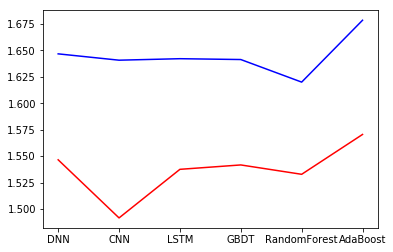

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(['DNN', 'CNN', 'LSTM', 'GBDT', 'RandomForest', 'AdaBoost'], [DNNacc, CNNacc, LSTMacc, GBDTacc, RFacc, AdaBoostacc], 'red', label='indicator')
plt.plot(['DNN', 'CNN', 'LSTM', 'GBDT', 'RandomForest', 'AdaBoost'], [DNNacc2, CNNacc2, LSTMacc2, GBDTacc2, RFacc2, AdaBoostacc2], 'blue', label='raw')

### Comparing Different N & Sample Gaps
Using LSTM model as an example, we can show the different accuracy or say, MSE loss by choosing distinct value of n & sample gaps & sequence length

In [4]:
def LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    model = Sequential()
    model.add(LSTM(128, input_length=train_input.shape[1], input_dim=train_input.shape[2], return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    LSTMIndicatorPred = model.predict(test_input)
    LSTMacc = np.std(LSTMIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return LSTMacc

NSS = [[10, 50, 50], [10, 100, 100], [50, 50, 50], [50, 50, 100], [100, 50, 100], [100, 100, 100]]
accs = []
for nss in NSS:
    N, seq_len, sample_gap = nss
    if os.path.exists(path="./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
        with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
            (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
    else:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
        with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
            data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
            pickle.dump(data_list, save_data)
    
    LSTMacc = LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label)
    accs.append(LSTMacc)
    

/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, input_shape=(50, 108), return_sequences=True)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 128)           121344    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 157,665
Trainable params: 157,665
Non-trainable params: 0
_________________________________________________________________
Train on 9012 samples, validate on 1127 samples
Epoch 1/3
9012/9012 [==============================] - 32s 4ms/step - loss: 2.1649 - val_loss: 2.7724
Epoch 2/3
9012/9012 [==============================] - 29s 3ms/step - loss: 2.1365 - val_loss: 2.7695
Epoch 3/3
9012/9

/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, input_shape=(100, 108), return_sequences=True)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 128)          121344    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 157,665
Trainable params: 157,665
Non-trainable params: 0
_________________________________________________________________
Train on 4452 samples, validate on 556 samples
Epoch 1/3
4452/4452 [==============================] - 33s 7ms/step - loss: 2.1655 - val_loss: 2.4160
Epoch 2/3
4452/4452 [==============================] - 33s 7ms/step - loss: 2.1391 - val_loss: 2.3849
Epoch 3/3
4452/44

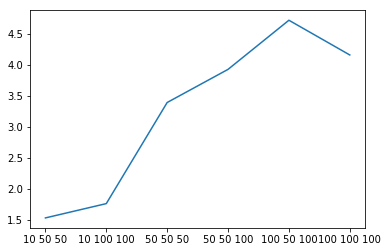

In [5]:
plt.figure()
plt.plot(["10 50 50", "10 100 100", "50 50 50", "50 50 100", "100 50 100", "100 100 100"], accs)

### Now we compare the raw model and with PCA to show the effect of PCA

In [17]:
N = 10
seq_len = 30
sample_gap = 30

if os.path.exists(path="./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
    with open("./indicator_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)
        
train_input = train_input.reshape(train_input.shape[0], -1)
dev_input = dev_input.reshape(dev_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)

accs3 = []
regressor = AdaRegress(train_input, np.array(train_label), 100, 0)

AdaIndicatorPred = regressor.predict(test_input)
AdaBoostacc3 = np.std(AdaIndicatorPred - np.array(test_label))
accs3.append(AdaBoostacc3)
print("AdaBoost", AdaBoostacc3)

AdaBoost 1.5397229009697102


In [18]:
model = Sequential()
model.add(Dense(128, input_shape=(train_input.shape[1], ), kernel_initializer='uniform', activation='sigmoid', kernel_regularizer=keras.regularizers.l1(0.)))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.summary()

callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

DNNRawPred = model.predict(test_input)
DNNacc3 = np.std(DNNRawPred - test_label.reshape(test_label.shape[0], 1))
accs3.append(DNNacc3)
print("DNN", DNNacc3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               414848    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 419,249
Trainable params: 419,249
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 6s 419us/step - loss: 2.3779 - val_loss: 2.2221
Epoch 2/3
15091/15091 [==============================] - 5s 319us/step - loss: 2.2666 - val_loss: 2.1670
Epoch 3/3

In [19]:
regressor = GBDTRegress(train_input, np.array(train_label), 2, 0)

GBDTRawPred = regressor.predict(test_input)
GBDTacc3 = np.std(GBDTRawPred - np.array(test_label))
accs3.append(GBDTacc3)
print("GBDT", GBDTacc3)

GBDT 1.5003095620657034


In [20]:
regressor = RandomForestRegress(train_input, np.array(train_label), 2, 0, 100)

RFRawPred = regressor.predict(test_input)
RFacc3 = np.std(RFRawPred - np.array(test_label))
accs3.append(RFacc3)
print("RandomForest", RFacc3)

RandomForest 1.4908335653635423


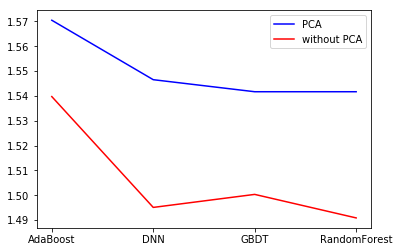

In [21]:
PCAAcc = [1.5704781815193638, 1.5465264107079268, 1.5416751363111998, 1.5416751363111998]
plt.figure()
plt.plot(['AdaBoost', 'DNN', 'GBDT', 'RandomForest'], PCAAcc, color='blue', label='PCA')
plt.plot(['AdaBoost', 'DNN', 'GBDT', 'RandomForest'], accs3, color='red', label='without PCA')
plt.legend()